In [82]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# SQL database connection
import sqlite3

# Data fetching from URLs
import requests
import tarfile
from io import BytesIO

# Data cleaning and regex operations
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose
# Configure display options
%matplotlib inline
plt.style.use('ggplot')  # Using 'ggplot' as a default style, similar to Seaborn aesthetics

# Suppress warnings (optional, but can help keep output clean)
import warnings
warnings.filterwarnings('ignore')


In [6]:

# Paths to the SQLite database files in the /data directory
fivethirtyeight_db = '../data/fivethirtyeight_data.db'
jamesqo_db = '../data/jamesqo_data.db'

# Function to load all data from a specified table in an SQLite database into a DataFrame
def load_all_data_from_sqlite(db_path, table_name):
    conn = sqlite3.connect(db_path)
    data = pd.read_sql(f"SELECT * FROM {table_name};", conn)
    conn.close()
    return data

# Load all rows from the cleaned datasets into DataFrames
fivethirtyeight_data = load_all_data_from_sqlite(fivethirtyeight_db, 'fivethirtyeight_data')
jamesqo_data = load_all_data_from_sqlite(jamesqo_db, 'jamesqo_data')

# Display a summary of the loaded DataFrames
print("FiveThirtyEight Dataset:")
print(fivethirtyeight_data.info())  # Shows info about columns and data types
print(fivethirtyeight_data.head())  # Displays the first few rows

print("\nJamesqo Dataset:")
print(jamesqo_data.info())  # Shows info about columns and data types
print(jamesqo_data.head())  # Displays the first few rows


FiveThirtyEight Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98015 entries, 0 to 98014
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       98015 non-null  int64  
 1   month      98015 non-null  int64  
 2   intent     98015 non-null  object 
 3   police     98015 non-null  int64  
 4   sex        98015 non-null  object 
 5   age        98015 non-null  float64
 6   race       98015 non-null  object 
 7   hispanic   98015 non-null  int64  
 8   place      98015 non-null  object 
 9   education  98015 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 7.5+ MB
None
   year  month   intent  police sex   age                    race  hispanic  \
0  2012      1  suicide       0   M  34.0  asian/pacific islander       100   
1  2012      1  suicide       0   F  21.0                   white       100   
2  2012      1  suicide       0   M  60.0                   white       100   
3  

In [8]:
jamesqo_data.head(3)


,incident_id,date,state,city_or_county,n_killed,n_injured,gun_stolen,gun_type,incident_characteristics,latitude,longitude,n_guns_involved,year,month
0,461105,2013-01-01 00:00:00,Pennsylvania,Mckeesport,0,4,unknown,unknown,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,-79.8559,0.0,2013,1
1,460726,2013-01-01 00:00:00,California,Hawthorne,1,3,unknown,unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,-118.3330,0.0,2013,1
2,478855,2013-01-01 00:00:00,Ohio,Lorain,1,3,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,-82.1377,2.0,2013,1


In [10]:
fivethirtyeight_data.head()

,year,month,intent,police,sex,age,race,hispanic,place,education
0,2012,1,suicide,0,M,34.0,asian/pacific islander,100,home,ba+
1,2012,1,suicide,0,F,21.0,white,100,street,some college
2,2012,1,suicide,0,M,60.0,white,100,other specified,ba+
3,2012,2,suicide,0,M,64.0,white,100,home,ba+
4,2012,2,suicide,0,M,31.0,white,100,other specified,hs/ged


In [12]:
print("Columns in Jamesqo Dataset:")
print(jamesqo_data.columns)

print("\nColumns in FiveThirtyEight Dataset:")
print(fivethirtyeight_data.columns)


Columns in Jamesqo Dataset:
Index(['incident_id', 'date', 'state', 'city_or_county', 'n_killed',
       'n_injured', 'gun_stolen', 'gun_type', 'incident_characteristics',
       'latitude', 'longitude', 'n_guns_involved', 'year', 'month'],
      dtype='object')

Columns in FiveThirtyEight Dataset:
Index(['year', 'month', 'intent', 'police', 'sex', 'age', 'race', 'hispanic',
       'place', 'education'],
      dtype='object')


In [14]:
# Assuming `jamesqo_data` DataFrame is already loaded and cleaned
# Aggregate by state and city to find the top hotspots based on fatalities and injuries

# Step 1.1: Group by state and city to calculate total incidents (killed and injured)
hotspots = jamesqo_data.groupby(['state', 'city_or_county']).agg({
    'n_killed': 'sum',
    'n_injured': 'sum'
}).reset_index()

# Step 1.2: Sort by highest incidents to identify top hotspots
hotspots = hotspots.sort_values(by=['n_killed', 'n_injured'], ascending=False)
print("Top 10 Hotspots by Fatalities and Injuries:")
print(hotspots.head(10))  # Display top 10 hotspots


Top 10 Hotspots by Fatalities and Injuries:
              state city_or_county  n_killed  n_injured
4070       Illinois        Chicago      2104      10427
15163         Texas        Houston      1144       1245
6592       Maryland      Baltimore      1055       2427
8840       Missouri    Saint Louis       916       1782
13500  Pennsylvania   Philadelphia       890       2318
6191      Louisiana    New Orleans       703       1892
1558     California    Los Angeles       636        553
14613     Tennessee        Memphis       622       1690
4738        Indiana   Indianapolis       616       1131
7291       Michigan        Detroit       603       1025


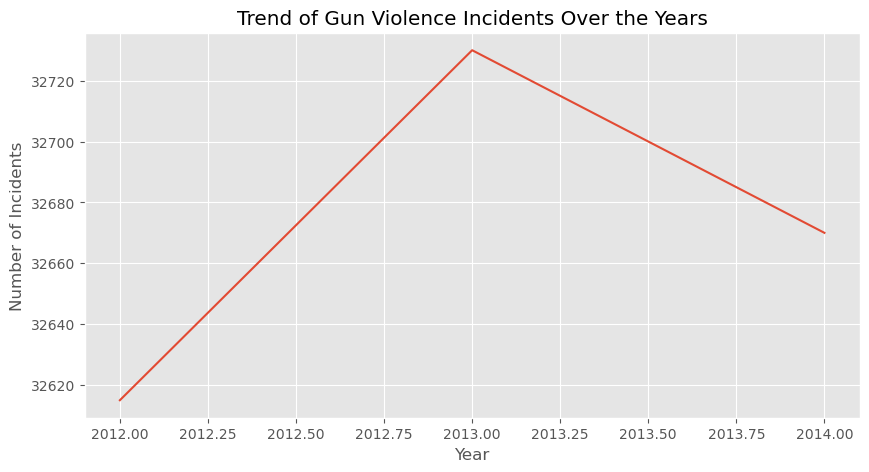

In [16]:
# Assuming 'fivethirtyeight_data' DataFrame is already loaded and contains the columns 'year'
yearly_incidents = fivethirtyeight_data.groupby('year').size()

plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_incidents.index, y=yearly_incidents.values)
plt.title('Trend of Gun Violence Incidents Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()


<Figure size 2000x1800 with 0 Axes>

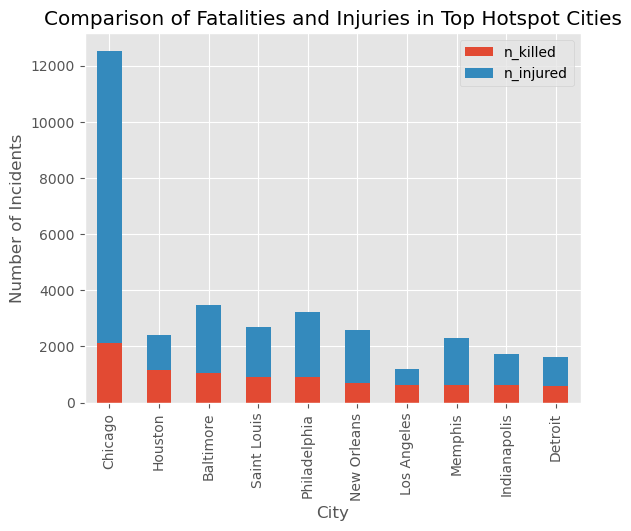

In [26]:
top_cities = jamesqo_data.groupby('city_or_county').agg({'n_killed': 'sum', 'n_injured': 'sum'}).nlargest(10, 'n_killed')

plt.figure(figsize=(20, 18))
top_cities[['n_killed', 'n_injured']].plot(kind='bar', stacked=True)
plt.title('Comparison of Fatalities and Injuries in Top Hotspot Cities')
plt.xlabel('City')
plt.ylabel('Number of Incidents')
plt.show()


In [20]:

# Group by state, sum fatalities and injuries
top_states = jamesqo_data.groupby('state').agg({'n_killed': 'sum', 'n_injured': 'sum'}).reset_index()

# Add a new column for the total of fatalities and injuries combined
top_states['Total_Incidents'] = top_states['n_killed'] + top_states['n_injured']

# Sort by Total_Incidents in descending order and select the top 10 states
top_states = top_states.sort_values(by='Total_Incidents', ascending=False).head(10)

# Print a report
print("Top 10 States with Highest Combined Fatalities and Injuries")
print("----------------------------------------------------------")
print(top_states.to_string(index=False, header=["State", "Total Fatalities", "Total Injuries", "Combined Total Incidents"]))


Top 10 States with Highest Combined Fatalities and Injuries
----------------------------------------------------------
         State Total Fatalities Total Injuries Combined Total Incidents
      Illinois             3409          13514                    16923
    California             5562           7644                    13206
         Texas             5046           6106                    11152
       Florida             3909           7072                    10981
          Ohio             2508           5703                     8211
  Pennsylvania             2395           5056                     7451
North Carolina             2225           4629                     6854
      New York             1705           5059                     6764
     Louisiana             2179           4398                     6577
       Georgia             2456           4056                     6512


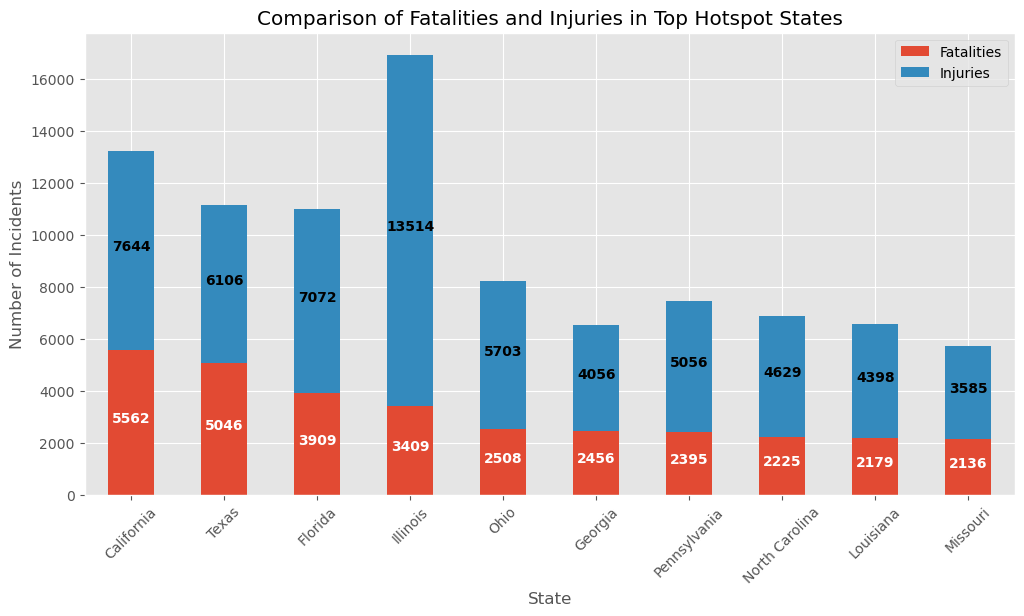

In [28]:


# Assuming 'jamesqo_data' DataFrame is already loaded and contains 'state', 'n_killed', and 'n_injured' columns

# Group by state, sum fatalities and injuries, and select the top 10 states by fatalities
top_states = jamesqo_data.groupby('state').agg({'n_killed': 'sum', 'n_injured': 'sum'}).nlargest(10, 'n_killed').reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = top_states.set_index('state')[['n_killed', 'n_injured']].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Comparison of Fatalities and Injuries in Top Hotspot States')
plt.xlabel('State')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(['Fatalities', 'Injuries'])

# Add numbers on top of each bar
for i, row in top_states.iterrows():
    # Position for fatalities
    ax.text(i, row['n_killed'] / 2, int(row['n_killed']), ha='center', color='white', weight='bold')
    # Position for injuries
    ax.text(i, row['n_killed'] + (row['n_injured'] / 2), int(row['n_injured']), ha='center', color='black', weight='bold')

plt.show()


In [30]:

# Assuming 'jamesqo_data' is your DataFrame containing the relevant data
# Group by state and city, summing fatalities
city_fatalities = jamesqo_data.groupby(['state', 'city_or_county']).agg({'n_killed': 'sum'}).reset_index()

# Sort the results first by state then by fatalities within each state
city_fatalities.sort_values(by=['state', 'n_killed'], ascending=[True, False], inplace=True)

# To further analyze and visualize, you might want to see the top cities in each state,
# This line of code shows the top 3 cities per state as an example:
top_cities_per_state = city_fatalities.groupby('state').head(3)


In [32]:
top_cities_per_state

,state,city_or_county,n_killed
41,Alabama,Birmingham,364
338,Alabama,Montgomery,174
330,Alabama,Mobile,161
489,Alaska,Anchorage,108
528,Alaska,Fairbanks,36
...,...,...,...
17261,Wisconsin,Madison,32
17366,Wisconsin,Racine,17
17494,Wyoming,Cheyenne,18
17491,Wyoming,Casper,13


In [34]:

# Group by state, sum fatalities and injuries
top_city = jamesqo_data.groupby('city_or_county').agg({'n_killed': 'sum', 'n_injured': 'sum'}).reset_index()

# Add a new column for the total of fatalities and injuries combined
top_city['Total_Incidents'] = top_city['n_killed'] + top_states['n_injured']

# Sort by Total_Incidents in descending order and select the top 10 states
top_city = top_city.sort_values(by='Total_Incidents', ascending=False).head(10)

# Print a report
print("Top 10 City with Highest Combined Fatalities and Injuries")
print("----------------------------------------------------------")
print(top_city.to_string(index=False, header=["City", "Total Fatalities", "Total Injuries", "Combined Total Incidents"]))


Top 10 City with Highest Combined Fatalities and Injuries
----------------------------------------------------------
           City Total Fatalities Total Injuries Combined Total Incidents
Abbott Township                0              1                  13514.0
      Abbeville                7             20                   7651.0
         Abbott                2              0                   7074.0
     Abbotsford                4              2                   6110.0
    Abbottstown                0              0                   5703.0
       Aberdeen               17             38                   5073.0
        Abilene               25             49                   4654.0
       Abingdon                5              6                   4403.0
    Abercrombie                0              1                   4056.0
       Abington                2              3                   3587.0


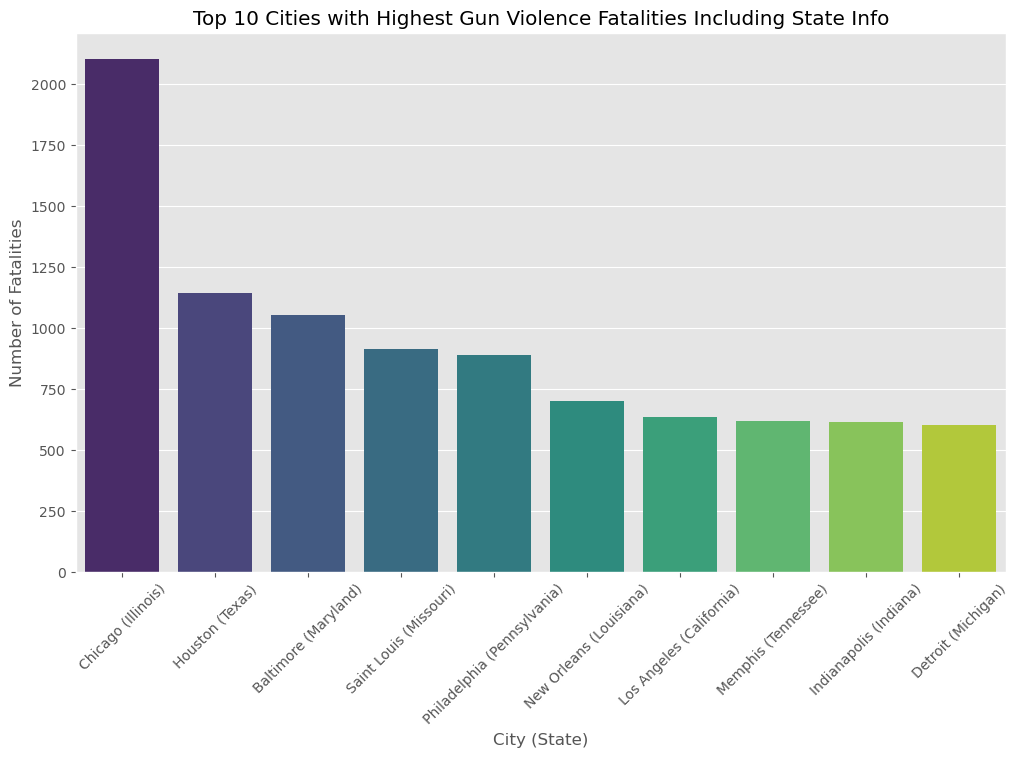

In [38]:

# Group by state and city, sum fatalities, and get the top 10 cities
top_cities_with_state = jamesqo_data.groupby(['state', 'city_or_county']).n_killed.sum().reset_index()
top_cities_with_state = top_cities_with_state.nlargest(10, 'n_killed')

# Creating a new column for better labeling in the plot
top_cities_with_state['city_state'] = top_cities_with_state['city_or_county'] + " (" + top_cities_with_state['state'] + ")"

# Plotting using seaborn for a cleaner look and automatic sorting
plt.figure(figsize=(12, 7))
sns.barplot(x='city_state', y='n_killed', data=top_cities_with_state, palette='viridis')
plt.xlabel('City (State)')
plt.ylabel('Number of Fatalities')
plt.title('Top 10 Cities with Highest Gun Violence Fatalities Including State Info')
plt.xticks(rotation=45)
plt.show()


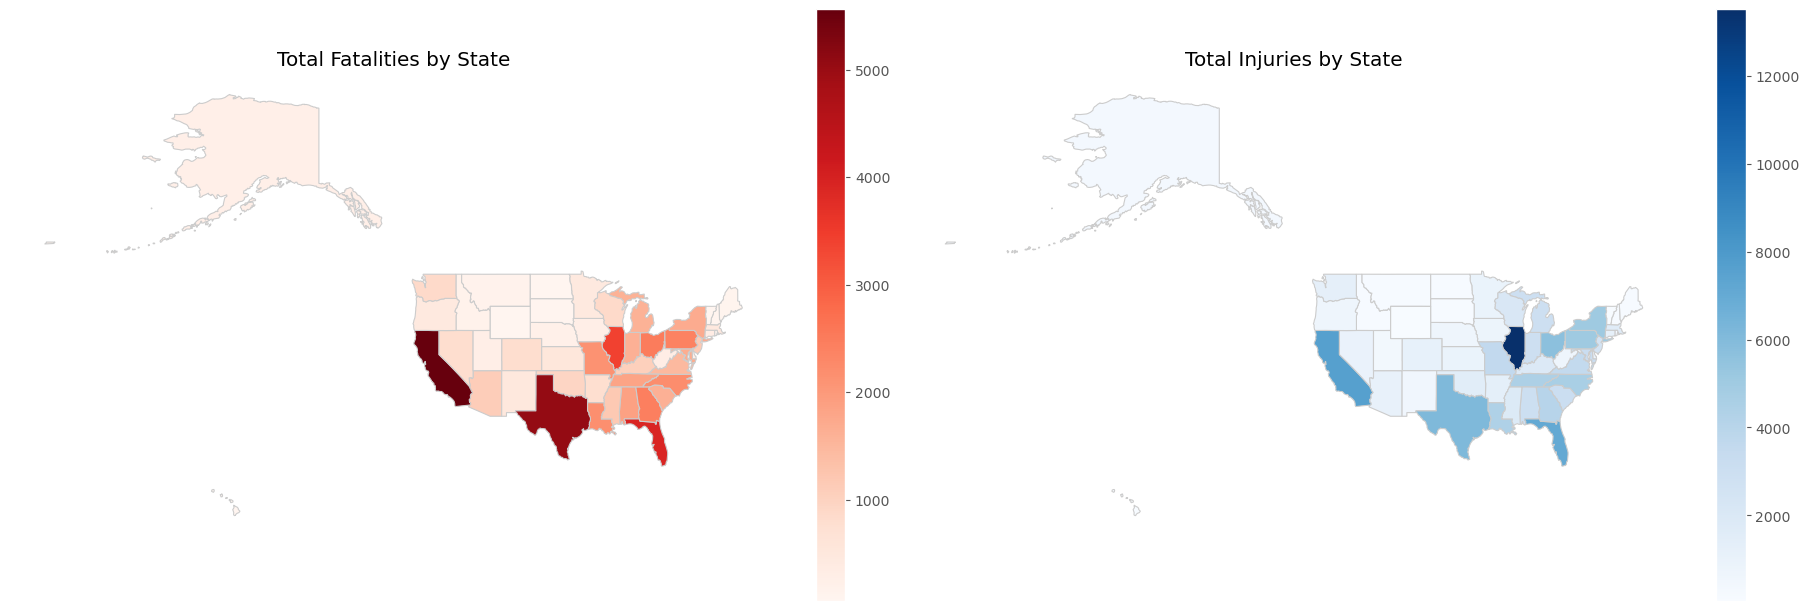

In [48]:

# Load U.S. states boundaries from an online GeoJSON file
us_states_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
us_states = gpd.read_file(us_states_url)

# Load data from SQLite database
db_path = '../data/jamesqo_data.db'
with sqlite3.connect(db_path) as conn:
    # Summarize fatalities and injuries per state
    query = """
    SELECT state, SUM(n_killed) AS Total_Fatalities, SUM(n_injured) AS Total_Injuries
    FROM jamesqo_data
    GROUP BY state;
    """
    data_df = pd.read_sql_query(query, conn)

# Rename columns for consistency
data_df.columns = ['State', 'Total_Fatalities', 'Total_Injuries']

# Merge U.S. states GeoDataFrame with gun violence data on the state name
geo_data = us_states.merge(data_df, how="left", left_on="name", right_on="State")

# Set up the figure and axes for the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

# Plot Total Fatalities by State
geo_data.plot(column='Total_Fatalities', cmap='Reds', linewidth=0.8, ax=axes[0], edgecolor='0.8', legend=True)
axes[0].set_title('Total Fatalities by State')
axes[0].axis('off')

# Plot Total Injuries by State
geo_data.plot(column='Total_Injuries', cmap='Blues', linewidth=0.8, ax=axes[1], edgecolor='0.8', legend=True)
axes[1].set_title('Total Injuries by State')
axes[1].axis('off')

# Display the plots
plt.show()


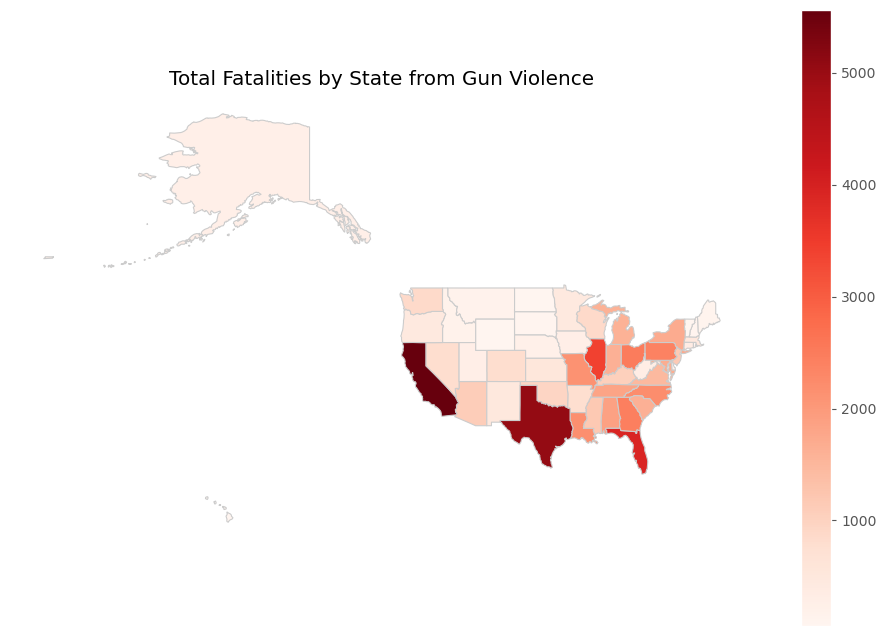

In [46]:
import pandas as pd

import matplotlib.pyplot as plt
import sqlite3

# Load U.S. states boundaries from an online GeoJSON file
us_states_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
us_states = gpd.read_file(us_states_url)

# Load data from SQLite database
db_path = '../data/jamesqo_data.db'
with sqlite3.connect(db_path) as conn:
    # Summarize fatalities per state
    query = """
    SELECT state, SUM(n_killed) AS Total_Fatalities
    FROM jamesqo_data
    GROUP BY state;
    """
    data_df = pd.read_sql_query(query, conn)

# Rename columns for consistency
data_df.columns = ['State', 'Total_Fatalities']

# Merge U.S. states GeoDataFrame with gun violence fatalities data
geo_data = us_states.merge(data_df, how="left", left_on="name", right_on="State")

# Set up the figure for the single map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot Total Fatalities by State
geo_data.plot(column='Total_Fatalities', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Total Fatalities by State from Gun Violence')
ax.axis('off')  # Turn off the axis for a cleaner look

# Display the map
plt.show()


In [52]:

# Count the number of incidents and sum fatalities for each state
state_violence = jamesqo_data.groupby('state').agg(
    Number_of_Incidents=('state', 'size'),  # Counts the total number of incidents per state
    Total_Fatalities=('n_killed', 'sum')    # Sums the total fatalities per state
).reset_index()

# Sort by Number_of_Incidents in descending order and select the top 10 states
top_10_states_violence = state_violence.sort_values(by='Number_of_Incidents', ascending=False).head(10)

# Print the report
print("Top 10 States with Most Frequent Violent Incidents and Total Fatalities")
print("----------------------------------------------------------------------")
print(top_10_states_violence.to_string(index=False, header=["State", "Number of Incidents", "Total Fatalities"]))


Top 10 States with Most Frequent Violent Incidents and Total Fatalities
----------------------------------------------------------------------
         State Number of Incidents Total Fatalities
      Illinois               17556             3409
    California               16306             5562
       Florida               15029             3909
         Texas               13577             5046
          Ohio               10244             2508
      New York                9712             1705
  Pennsylvania                8929             2395
       Georgia                8925             2456
North Carolina                8739             2225
     Louisiana                8103             2179


In [54]:

# Count the number of incidents and sum fatalities for each city
city_violence = jamesqo_data.groupby('city_or_county').agg(
    Number_of_Incidents=('city_or_county', 'size'),  # Counts the total number of incidents per city
    Total_Fatalities=('n_killed', 'sum')             # Sums the total fatalities per city
).reset_index()

# Sort by Number_of_Incidents in descending order and select the top 10 cities
top_10_cities_violence = city_violence.sort_values(by='Number_of_Incidents', ascending=False).head(10)

# Print the report
print("Top 10 Cities with Most Frequent Violent Incidents and Total Fatalities")
print("----------------------------------------------------------------------")
print(top_10_cities_violence.to_string(index=False, header=["City", "Number of Incidents", "Total Fatalities"]))


Top 10 Cities with Most Frequent Violent Incidents and Total Fatalities
----------------------------------------------------------------------
        City Number of Incidents Total Fatalities
     Chicago               10814             2104
   Baltimore                3943             1055
  Washington                3279              468
 New Orleans                3071              703
Philadelphia                2963              901
     Houston                2501             1145
 Saint Louis                2501              919
   Milwaukee                2487              486
Jacksonville                2448              467
     Memphis                2386              623


In [70]:

# Group by state, count the number of incidents and sum fatalities
state_success = jamesqo_data.groupby('state').agg(
    Number_of_Incidents=('state', 'size'),  # Counts the total number of incidents per state
    Total_Fatalities=('n_killed', 'sum')    # Sums the total fatalities per state
).reset_index()

# Calculate the fatalities per incident ratio
state_success['Fatality_Per_Incident_Ratio'] = state_success['Total_Fatalities'] / state_success['Number_of_Incidents']

# Sort by Fatality_Per_Incident_Ratio in ascending order to find states with the lowest ratio
state_success_sorted = state_success.sort_values(by='Fatality_Per_Incident_Ratio', ascending=True).head(10)

# Display the top states with the lowest fatality per incident ratio
print("Top States with Lowest Fatalities per Incident Ratio (Successful States in Combating Violence)")
print("------------------------------------------------------------------------------------------")
print(state_success_sorted.to_string(index=False, header=["State", "Number of Incidents", "Total Fatalities", "Fatality per Incident Ratio"]))


Top States with Lowest Fatalities per Incident Ratio (Successful States in Combating Violence)
------------------------------------------------------------------------------------------
        State Number of Incidents Total Fatalities Fatality per Incident Ratio
 Rhode Island                 895               63                    0.070391
Massachusetts                5981              472                    0.078917
New Hampshire                 964               88                    0.091286
         Iowa                2517              273                    0.108462
  Connecticut                3067              341                    0.111184
 North Dakota                 573               69                    0.120419
      Vermont                 472               57                    0.120763
        Maine                 907              112                    0.123484
     Delaware                1685              217                    0.128783
     Nebraska           

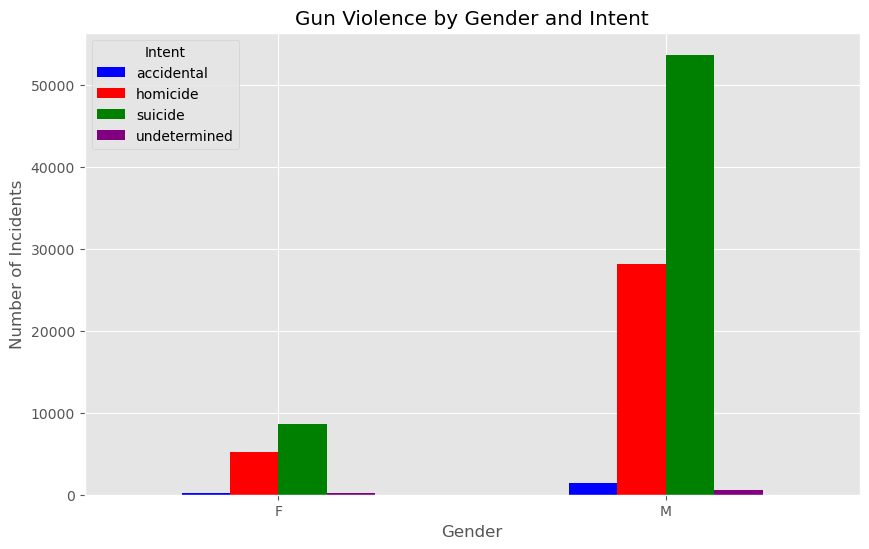

In [72]:
# Count incidents by gender and intent
gender_intent = fivethirtyeight_data.groupby(['sex', 'intent']).size().unstack()

# Plot
gender_intent.plot(kind='bar', figsize=(10, 6), color=['blue', 'red', 'green', 'purple'])
plt.title('Gun Violence by Gender and Intent')
plt.xlabel('Gender')
plt.ylabel('Number of Incidents')
plt.legend(title='Intent')
plt.xticks(rotation=0)
plt.show()


Counts by Education Level:
education
hs/ged          42258
less than hs    21448
some college    21430
ba+             12879
Name: count, dtype: int64

Percentage by Education Level:
education
hs/ged          43.11
less than hs    21.88
some college    21.86
ba+             13.14
Name: count, dtype: float64


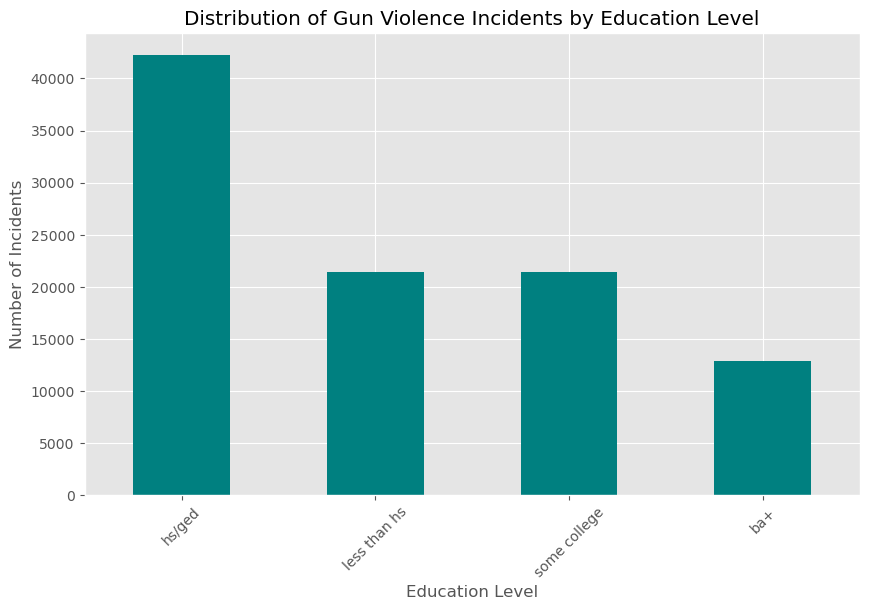

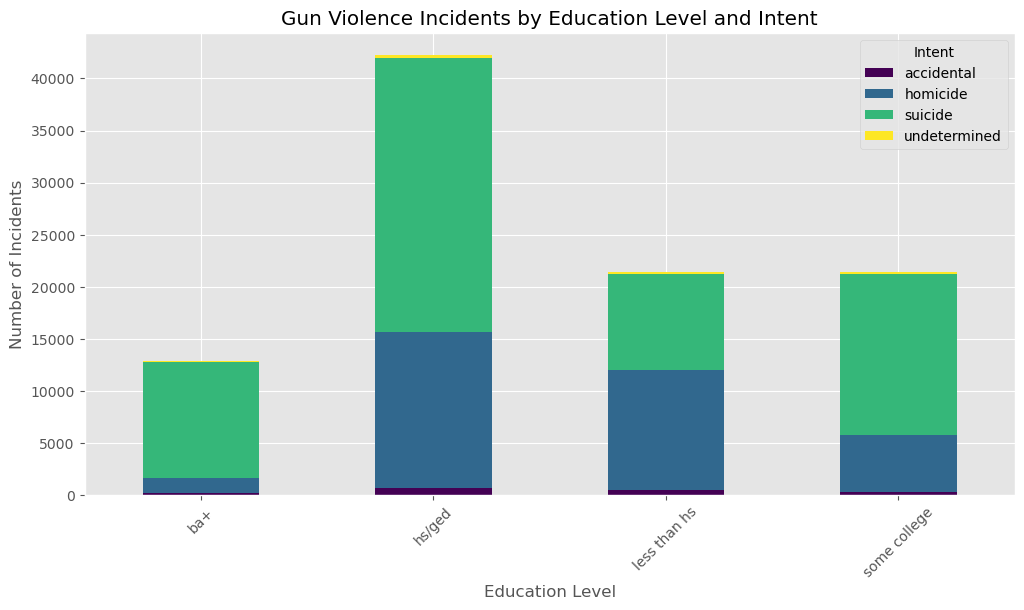

In [78]:

# Count incidents by education level
education_counts = fivethirtyeight_data['education'].value_counts(dropna=False)
total_incidents = fivethirtyeight_data.shape[0]
education_percentage = (education_counts / total_incidents) * 100

# Display counts and percentages of each education level
print("Counts by Education Level:")
print(education_counts)
print("\nPercentage by Education Level:")
print(education_percentage.round(2))

# Plotting the distribution of incidents by education level
plt.figure(figsize=(10, 6))
education_counts.plot(kind='bar', color='teal')
plt.title('Distribution of Gun Violence Incidents by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()

# Analyzing education level by intent (e.g., homicide, suicide)
education_intent = fivethirtyeight_data.groupby(['education', 'intent']).size().unstack()

# Plotting a stacked bar chart for education level by intent
education_intent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Gun Violence Incidents by Education Level and Intent')
plt.xlabel('Education Level')
plt.ylabel('Number of Incidents')
plt.legend(title='Intent')
plt.xticks(rotation=45)
plt.show()


Counts by Education Level in Criminal Incidents:
education
hs/ged          14980
less than hs    11465
some college     5391
ba+              1493
Name: count, dtype: int64

Percentage by Education Level in Criminal Incidents:
education
hs/ged          44.95
less than hs    34.40
some college    16.18
ba+              4.48
Name: count, dtype: float64


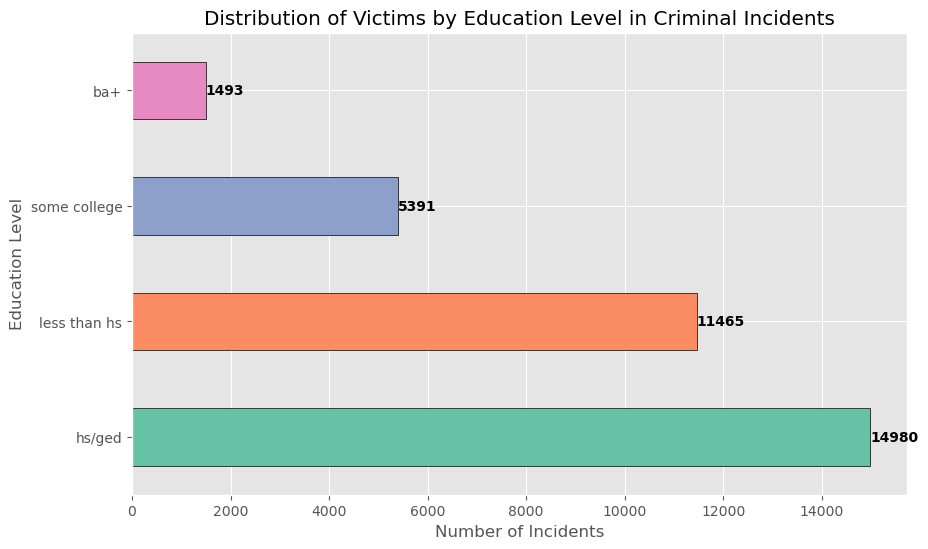

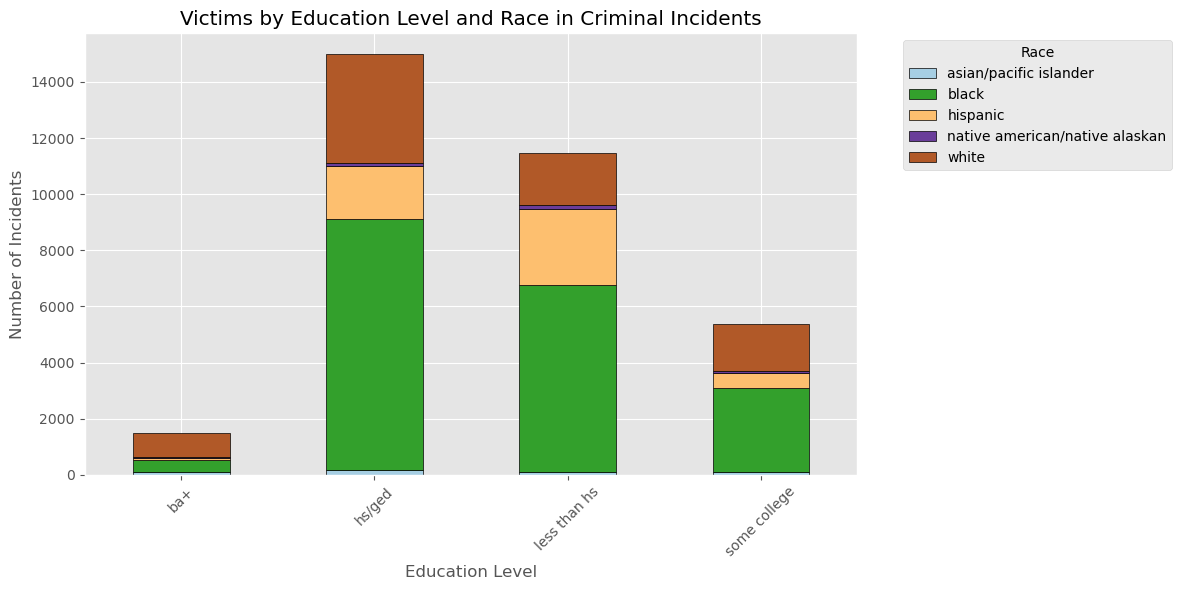

In [80]:

# Filter data for criminal incidents (e.g., intent == "homicide")
criminal_data = fivethirtyeight_data[fivethirtyeight_data['intent'] == 'homicide']

# Count victims by education level in criminal incidents
education_counts_criminal = criminal_data['education'].value_counts(dropna=False)
total_criminal_incidents = criminal_data.shape[0]
education_percentage_criminal = (education_counts_criminal / total_criminal_incidents) * 100

# Display counts and percentages of each education level in criminal incidents
print("Counts by Education Level in Criminal Incidents:")
print(education_counts_criminal)
print("\nPercentage by Education Level in Criminal Incidents:")
print(education_percentage_criminal.round(2))

# Plotting a horizontal bar chart with different colors for each bar and annotations for the distribution of victims by education level
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(education_counts_criminal))  # Use Seaborn's "Set2" color palette for distinct colors
ax = education_counts_criminal.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Distribution of Victims by Education Level in Criminal Incidents')
plt.xlabel('Number of Incidents')
plt.ylabel('Education Level')

# Annotate each bar with the number of incidents
for index, value in enumerate(education_counts_criminal):
    ax.text(value, index, f'{value}', va='center', color='black', fontweight='bold')

plt.show()

# Optional: Analyzing education level by race within criminal incidents
education_race_criminal = criminal_data.groupby(['education', 'race']).size().unstack()

# Plotting a stacked bar chart for education level by race in criminal incidents
education_race_criminal.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Paired', edgecolor='black')
plt.title('Victims by Education Level and Race in Criminal Incidents')
plt.xlabel('Education Level')
plt.ylabel('Number of Incidents')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


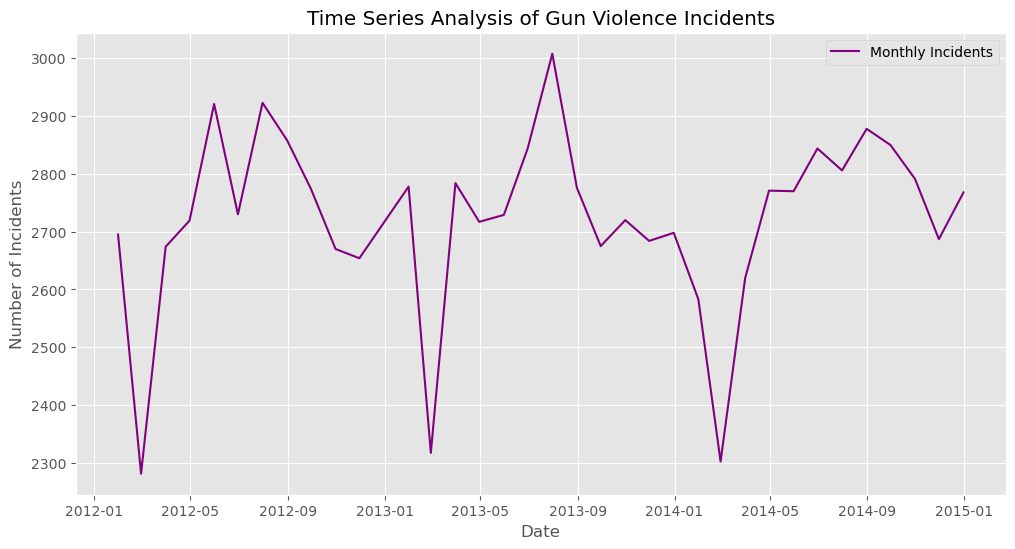

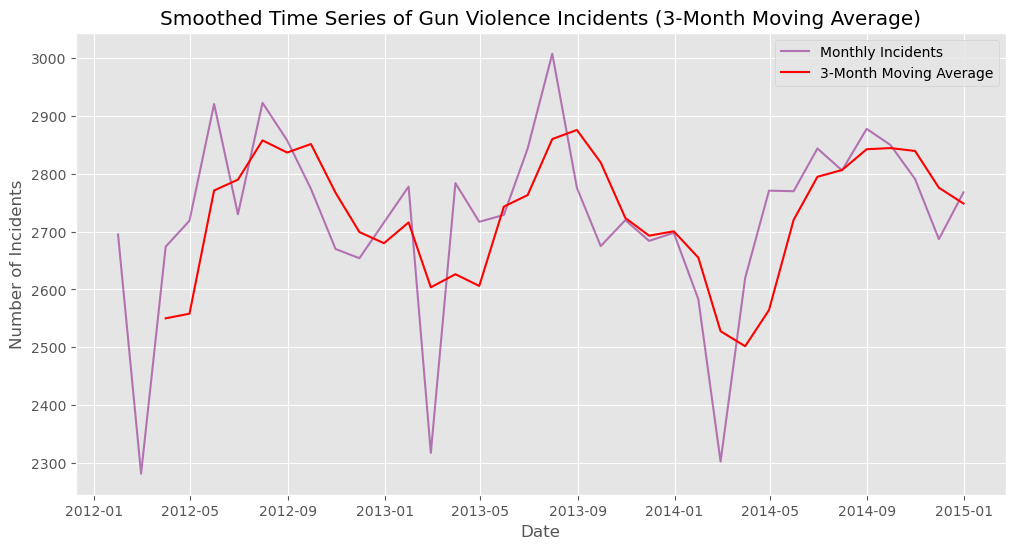

In [92]:

# Assuming 'fivethirtyeight_data' DataFrame contains 'year' and 'month' columns

# Create a 'date' column by combining 'year' and 'month'
fivethirtyeight_data['date'] = pd.to_datetime(fivethirtyeight_data[['year', 'month']].assign(day=1))

# Set the 'date' column as the index for time series analysis
fivethirtyeight_data.set_index('date', inplace=True)

# Aggregate the number of incidents by month
monthly_data = fivethirtyeight_data.resample('M').size()

# Plotting the time series to observe patterns
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, color='purple', label='Monthly Incidents')
plt.title('Time Series Analysis of Gun Violence Incidents')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()

# Applying a moving average to smooth the data (window of 3 months)
monthly_data_smooth = monthly_data.rolling(window=3).mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_data, color='purple', alpha=0.5, label='Monthly Incidents')
plt.plot(monthly_data_smooth, color='red', label='3-Month Moving Average')
plt.title('Smoothed Time Series of Gun Violence Incidents (3-Month Moving Average)')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()



